* Wrangle your data. Get it into the notebook in the best form possible for your analysis and model building.

* Explore your data. Make visualizations and conduct statistical analyses to explain what’s happening with your data, why it’s interesting, and what features you intend to take advantage of for your modeling.

* Build a modeling pipeline. Your model should be build in a coherent pipeline of linked stages that is efficient and easy to implement.

* Evaluate your models. You should have built multiple models, which you should thoroughly evaluate and compare via a robust analysis of residuals and failures.

* Present and thoroughly explain your product. Describe your model in detail: why you chose it, why it works, what problem it solves, how it will run in a production like environment. What would you need to do to maintain it going forward?

In [1]:
import pandas as pd
import numpy as np
import sys
import time
import random
import matplotlib.pyplot as plt
import ccxt
import os
import statistics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
%matplotlib inline

Historical market cap was downloaded from https://coin.dance/stats/marketcaphistorical.

Cleaning historical market cap

In [ ]:
file = 'data/historical_market_cap_unformatted.xlsx'
df = pd.read_excel(file)

# convert date column to epoch time
df = df.rename(columns={'Label': 'date'})

dates = pd.DatetimeIndex(df['date'])
dates = list(dates.astype(np.int64) / 10 **9)

df['date'] = dates

# # Total market cap
df['Total Market Cap'] = df['Altcoin Market Cap'] + df['Bitcoin Market Cap']

# # Save file
df.set_index('date', drop=True, inplace=True)
df.to_csv('data/historical_market_cap.csv')

Pulling historical prices

In [ ]:
# pull epoch dates used for market caps
market_cap = pd.read_csv(data/historical market cap.csv')
dates_epoch = market_cap['date']
date_range = [time.strftime('%m/%d/%Y', time.localtime(day)) for day in dates_epoch]

# Use coins listed on Bittrex
primary_exchange = ccxt.bittrex({'options': {'adjustForTimeDifference': True}})
market = primary_exchange.load_markets()
tickers = list(market.keys())

coins = set()
[[coins.add(coin) for coin in ticker.split('/') if coin != 'BTC'] for ticker in tickers]
coins = list(coins)

# Since we can't pull BTC/BTC, use BTC/USDT ticker.  Otherwise, use coin/BTC as ticker
tickers = [coin + '/BTC' for coin in coins]
coins.insert(0, 'BTC')
tickers.insert(0, 'BTC/USDT')

df = [list(dates_epoch)]
coins_to_simulate = []

for coin, ticker in zip(coins, tickers):
    # Pull information if ticker exists
    try:
        data = np.array(primary_exchange.fetch_ohlcv(ticker, '1d'))[:, :2]
    except:
        continue

    coin_prices = [price \
                   for day, price in data \
                   if time.strftime('%m/%d/%Y', time.localtime(day/1000)) in date_range]

    # Only add coin if it has a full year of price data
    if len(coin_prices) == len(dates):
        df.append(coin_prices)
        coins_to_simulate.append(coin)

# Add date to the front of coins to create column names
coins_to_simulate.insert(0, 'date')

df_np = np.array(df)

# Since all coins are in BTC denomination, multiply by BTC price to get $ price
df_np[2:] *= df[1]

new_df = pd.DataFrame(df_np.transpose(), columns=coins_to_simulate)

new_df.set_index('date', drop=True, inplace=True)
new_df.to_csv(os.getcwd() + '/backtests/historical prices.csv')


HODL and Rebalance functions

In [41]:
def simulate_HODL(num_coins):
    sims = pd.DataFrame(index=sim_dates)

    for sim_num in range(1000):
        # Randomly select basket of coins
        random_list = random.sample(range(len(coins)-1), num_coins)
        
        # Determine amount of each coin bought on day 0
        amt_each = 5000 / num_coins
        coin_amts = amt_each / hist_prices[0, random_list]

        # Use coins as column name
        col = '-'.join([coins[i] for i in random_list])

        # Dot multiply list of coin amounts with array of historical prices of selected coins
        sims[col] = hist_prices[:, random_list].dot(coin_amts)

    sims.to_csv('data/HODL.csv')
    return sims


def simulate_rebalance(num_coins, df):

    # Set the threshold of weight difference to trigger a trade
    rate = 0.001
    thresh = 0.05
    avg_weight = 1 / num_coins
    weighted_thresh = np.float32(avg_weight * thresh)

    # Exclude date column
    cols = df.columns.tolist()
    hodl_sims = np.array(df)

    # Create arrays to be transformed to CSV's
    sim_summary = [[] for x in range(len(cols))]
    rebalance_sims = np.empty(shape=(len(cols), len(hist_prices)))


    # Use the same coin combinations as the HODL simulation
    coin_lists = [col.split('-') for col in cols]

    # For each simulation, convert the symbol into the corresponding column # in hist_prices
    coin_lists_indices = [[coins.index(coin) for coin in coin_list] for coin_list in coin_lists]
    

    for num, (col, coin_list, coin_list_index) in enumerate(zip(cols, coin_lists, coin_lists_indices)):

        trade_count = 0
        fees = 0
        daily_totals = [start_amt]

        # Reduce hist_prices array to only the coins used in the simulation
        hist_prices_small = hist_prices[:, coin_list_index]

        # Calculate starting coin amounts
        amt_each = 5000 / num_coins
        coin_amts = amt_each / hist_prices_small[0]

        # Simulate each day
        for num_day in range(1,len(hist_prices)):
            while True:
                d_vals = hist_prices_small[num_day] * coin_amts
                d_vals_total = sum(d_vals)
                l_index, h_index = d_vals.argmin(), d_vals.argmax()

                # See how far the lightest and heaviest coin weight deviates from average weight
                weight_to_move = min([avg_weight - d_vals[l_index]/d_vals_total, d_vals[h_index]/d_vals_total - avg_weight])

                if weighted_thresh > weight_to_move:
                    break

                trade_count += 1

                d_amt = weight_to_move * d_vals_total
                fees += (d_amt * rate)

                # Get coin quantities to buy/sell based on current market price
                l_quantity = d_amt / hist_prices_small[num_day, l_index]
                h_quantity = d_amt / hist_prices_small[num_day, h_index]

                # Adjust coin quantities
                coin_amts[l_index] += (l_quantity * (1 - rate))
                coin_amts[h_index] -= h_quantity

            # document total portfolio value on that day
            daily_totals.append(np.dot(hist_prices_small[num_day], coin_amts))

        # Document important features of the sims
        end_price_HODL = hodl_sims[len(hodl_sims)-1, num]
        end_price_rebalanced = daily_totals[len(daily_totals)-1]
        sim_summary[num] = [col, fees, trade_count, end_price_HODL, end_price_rebalanced]
        rebalance_sims[num] = daily_totals

    rebalance_sims = pd.DataFrame(np.transpose(rebalance_sims), columns=cols, index=sim_dates)
    rebalance_sims.to_csv('data/rebalanced.csv')

    sim_summary = pd.DataFrame(sim_summary,columns=['portfolio','fees','num_trades','HODL','rebalanced'])
    sim_summary.to_csv('data/summary.csv', index=False)


Simulation

In [42]:
hist_prices = pd.read_csv('data/historical_prices.csv')

sim_dates = list(hist_prices['date'])
coins = hist_prices.columns.tolist()[1:]

# Exclude date column from historical prices
hist_prices = np.array(hist_prices[coins])

# get date ranges used for sims
hist_cap = pd.read_csv('data/historical_market_cap.csv')
hist_cap = np.array(hist_cap)

start_dates = hist_cap[:len(hist_cap) - 365]
end_dates = hist_cap[365:]

# Subtract the ending market caps from each other, located in the 4th column
cap_diffs = list(end_dates[:, 3] - start_dates[:, 3])

# Make sure there's an odd number of dates, so the median value can be indexed
if len(cap_diffs) % 2 == 0:
    cap_diffs.pop(len(cap_diffs)-1)

# Start date for sims
start_date = cap_diffs.index(np.median(cap_diffs))

# Limit dataframe dates to the date range
hist_prices = hist_prices[start_date:start_date + 365]
sim_dates = sim_dates[start_date:start_date + 365]

# Retrieve all current tickers on exchange
exchange = ccxt.bittrex()
tickers = set()
[tickers.add(ticker) for ticker in exchange.fetch_tickers()]

# Start with $5000 of Bitcoin at day 0 price
start_amt = 5000
num_coins = 5

print('Simulating HODL of {} coins...'.format(num_coins))
df = simulate_HODL(num_coins)
print('Finished\n')
print('Simulating rebalance of {} coins...'.format(num_coins))
simulate_rebalance(num_coins, df)
print('Finished')

Simulating HODL of 5 coins...
Finished

Simulating rebalance of 5 coins...
Finished


In [43]:
# DataFrames we've created
hist_prices = pd.read_csv('data/historical_prices.csv')
hodl_df = pd.read_csv('data/HODL.csv')
rebalanced_df = pd.read_csv(os.getcwd()  + '/data/rebalanced.csv')
summary_df = pd.read_csv(os.getcwd()  + '/data/summary.csv')

# Date range used for simulations
start_date, end_date = hist_prices['date'][0], hist_prices['date'][len(hist_prices)-1]
start_date = time.strftime('%m/%d/%Y', time.gmtime(start_date))
end_date = time.strftime('%m/%d/%Y', time.gmtime(end_date))


print('Coins used in analysis\n\n', coins)
print('\n\nDate range of simulation:\n {} - {}'.format(start_date, end_date)) 

Coins used in analysis

 ['BTC', 'WAVES', 'NEOS', 'BLK', 'POT', 'STRAT', 'AUR', 'NAV', 'VIA', 'VTC', 'PPC', 'CURE', 'NXT', 'GRC', 'NEO', 'DASH', 'MONA', 'AEON', 'STEEM', 'LTC', 'XCP', 'CLAM', 'EXP', 'NXS', 'ETH', 'XRP', 'AMP', 'DOGE', 'DCR', 'ENRG', 'BCY', 'REP', 'ETC', 'NLG', 'SYS', 'XLM', 'DGB', 'IOC', 'CLOAK', 'ZEC', 'LSK', 'SLR', 'BURST', 'EMC', 'SBD', 'XMR', 'FTC']


Date range of simulation:
 01/01/2017 - 09/12/2018


Remove outliers

In [61]:
# Function to only take results within 2 standard deviations
def reject_outliers(data, m = 2):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0
    return data[s < m]

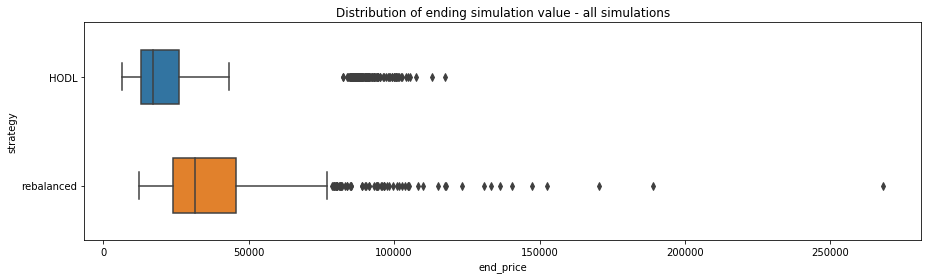

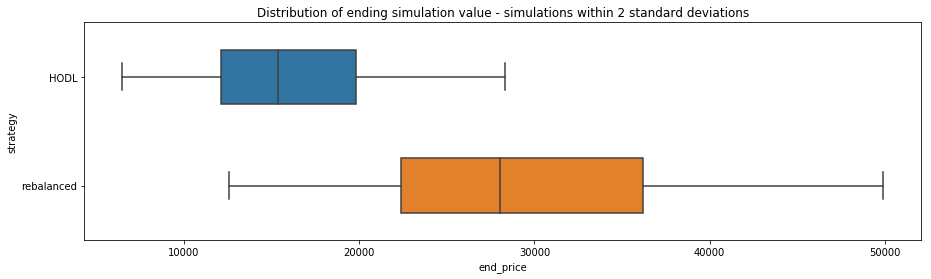

In [68]:
# DataFrame with all values
box_df = []
for hodl, rebalanced in zip(df['HODL'], df['rebalanced']):
    box_df.append(['HODL', hodl])
    box_df.append(['rebalanced', rebalanced])


hodl_2sdev = reject_outliers(df['HODL'])
rebalanced_2sdev = reject_outliers(df['rebalanced'])

# Create dataframe to be used for box plots
box_df_2sdev = []
for hodl, rebalanced in zip(hodl_2sdev, rebalanced_2sdev):
    box_df_2sdev.append(['HODL', hodl])
    box_df_2sdev.append(['rebalanced', rebalanced])


box_df = pd.DataFrame(box_df, columns=['strategy', 'end_price'])
box_df_2sdev = pd.DataFrame(box_df_2sdev, columns=['strategy', 'end_price'])

g1 = sns.boxplot(data=box_df, y='strategy', x='end_price', width=0.5)
g1.figure.set_size_inches(15,4)
g1.set_title('Distribution of ending simulation value - all simulations')
plt.show()

g2 = sns.boxplot(data=box_df_2sdev, y='strategy', x='end_price', width=0.5)
g2.figure.set_size_inches(15,4)
g2.set_title('Distribution of ending simulation value - simulations within 2 standard deviations')
plt.show()

C:\Users\18047\Python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


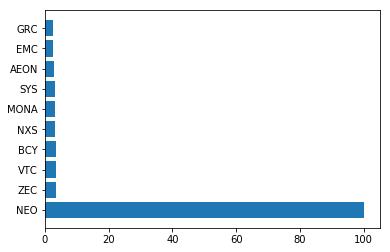

In [62]:
# Refresh our datasets
hodl_df = pd.read_csv('data/HODL.csv')
rebalanced_df = pd.read_csv(os.getcwd()  + '/data/rebalanced.csv')
summary_df = pd.read_csv(os.getcwd()  + '/data/summary.csv')
hist_prices = pd.read_csv('data/historical_prices.csv')

# list of coins used in each portfolio simulation
coins = hist_prices.columns[1:].tolist()
cols = hodl_df.columns[1:]
# For each simulation, make a list of the coins randomly chosen
coin_lists = [i.split('-') for i in cols]

# Dataframe to compare coin impact on outperforming HODL
tree_df = pd.DataFrame(columns=coins)
tree_df['beat market'] = (df['rebalanced'] - df['HODL']) / df['HODL']
tree_df.loc[tree_df['beat market'] > 0, 'beat market'] = True
tree_df.loc[tree_df['beat market'] < 0, 'beat market'] = False

# Replace NaN's with False
tree_df = tree_df.fillna(False)

# Fill Dataframe with coins used for each simulation
for i in range(len(coin_lists)):
    for coin in coin_lists[i]:
        tree_df.loc[i, coin] = True

# Feature importance analysis
tree = RandomForestClassifier()
X = tree_df[coins]
Y = tree_df['beat market']
tree.fit(X, Y)

feature_importance = tree.feature_importances_
feature_importance = 100 * (feature_importance / max(feature_importance))
temp = feature_importance.tolist()

# Take only top 10 features
top_feats = sorted(feature_importance,reverse=True)[:10]
sorted_features = np.array([temp.index(feat) for feat in top_feats])
pos = np.arange(sorted_features.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_features], align='center')
plt.yticks(pos, X.columns[sorted_features])
plt.show()

In [70]:
tree_df.groupby('beat market')['beat market'].count()

beat market
False     96
True     904
Name: beat market, dtype: int64